In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy import stats

from subprocess import check_output

# Any results you write to the current directory are saved as output.
import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", color_codes=True)

In [2]:
data = pd.read_csv('full_data_new.csv')

In [3]:
small_data = data[['Latitude', 'Longitude', 'Date']]

Getting data for all 4 subway stations

- Waterloo
- Kings Cross St. Pancras
- Victoria
- Oxford Circus

**First calculating accidents in the most crowded regions of London with all the subway stations**

In [4]:
factor_lat = 0.00898892564 # KMs in 1 degree lat
factor_lon = 0.01424562303 # KMs in 1 degree lon

In [5]:
lat_max = 51.530312 + 6*factor_lat
lat_min = 51.496424 - 6*factor_lat
lon_min = -0.143906 - 6*factor_lon
lon_max = -0.113245 + 6*factor_lon

In [6]:
loc_data_crowded = small_data.loc[(small_data['Latitude'] < lat_max)&
                          (small_data['Latitude'] > lat_min)&
                          (small_data['Longitude'] < lon_max)&
                          (small_data['Longitude'] > lon_min)]

**Now calculating accidents in other regions of London with less trafic and are far away from subway stations**

In [7]:
other_data = small_data[~small_data.isin(loc_data_crowded)].dropna()

In [8]:
lat_max = 51.530312 + 8.5*factor_lat
lat_min = 51.496424 - 8.5*factor_lat
lon_min = -0.143906 - 8.5*factor_lon
lon_max = -0.113245 + 8.5*factor_lon

In [9]:
loc_data_other = other_data.loc[(other_data['Latitude'] < lat_max)&
                          (other_data['Latitude'] > lat_min)&
                          (other_data['Longitude'] < lon_max)&
                          (other_data['Longitude'] > lon_min)]

In [10]:
loc_data_other.shape

(36545, 3)

In [11]:
loc_data_crowded.shape

(92006, 3)

In [12]:
crowded_dist = list(loc_data_crowded.groupby(['Date']).count().Latitude)
other_dist = list(loc_data_other.groupby(['Date']).count().Latitude)

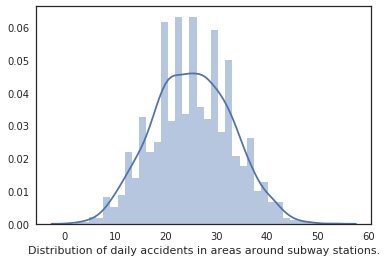

In [13]:
sns.distplot(crowded_dist, axlabel='Distribution of daily accidents in areas around subway stations.')

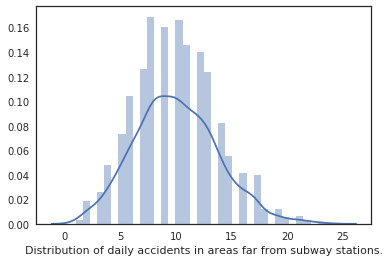

In [14]:
sns.distplot(other_dist, axlabel='Distribution of daily accidents in areas far from subway stations.')

In [15]:
mean_crowded = np.mean(crowded_dist)
mean_other = np.mean(other_dist)

**Confidence Intervals test**

In [16]:
z_score = 1.645

In [20]:
crowded_var = np.var(crowded_dist)
other_var = np.var(other_dist)

ci_max = (mean_crowded - mean_other) + (z_score*np.sqrt(crowded_var + other_var))
ci_min = (mean_crowded - mean_other) - (z_score*np.sqrt(crowded_var + other_var))


In [21]:
ci_max

29.441394563262868

In [22]:
ci_min

0.9260700663019303

In [23]:
stats.ttest_ind(crowded_dist, other_dist, equal_var=False)

Ttest_indResult(statistic=105.85003849170909, pvalue=0.0)

Reject the Null hypothesis that the number of daily accidents are equal

**KS Test**

In [88]:
stats.ks_2samp(crowded_dist, other_dist)

Ks_2sampResult(statistic=0.734363464165169, pvalue=0.0)

Since the p value is zero, the datapoints don't follow the same distribution. 

In [25]:
def run_permutation_test(pooled,sizeZ,sizeY,delta):
    np.random.shuffle(pooled)
    starZ = pooled[:sizeZ]
    starY = pooled[-sizeY:]
    return starZ.mean() - starY.mean()
pooled = np.hstack([crowded_dist, other_dist])
delta = mean_crowded - mean_other
numSamples = 10000
estimates = list(map(lambda x: run_permutation_test(pooled,len(crowded_dist),len(other_dist),delta),range(numSamples)))
diffCount = len(np.where(estimates <= delta)[0])
hat_asl_perm = 1.0 - (float(diffCount)/float(numSamples))
hat_asl_perm

0.0